In [26]:
!pwd

/Users/yoelwoldeyes


# Malicious DNS-over-HTTP Traffic Detection using Autoencoders

Welcome to this Jupyter Notebook! We will explore the use of autoencoder for anomaly detection of malicious DoH traffic. The notebook will guide your through loading a DoH traffic dataset, designing an autoencoder, training an autoencoder,  and evaluating their effectiveness in identifying malicious traffic. 

## Load the dataset

We will be using the same training, testing, and evaluation dataset we used for our ML models. 


In [1]:
# Import the Pandas library
import pandas as pd
import tensorflow

# Load the datasets
data_training   = pd.read_csv('data_training.csv')
data_testing    = pd.read_csv('data_testing.csv')
data_evaluation = pd.read_csv('data_evaluation.csv')

In [2]:
data_training

,bytes_out,num_pkts_out,bytes_in,num_pkts_in,bytes_ration,num_pkts_ration,time,av_pkt_size_in,av_pkt_size_out,var_pkt_size_in,var_pkt_size_out,median_in,median_out,mindelay,avgdelay,maxdelay,is_doh
0,0.138582,0.161498,0.131184,0.161182,0.315229,0.639265,0.999518,0.131496,0.304707,0.029583,0.087705,0.245385,0.304707,0.0,0.281430,0.272718,1
1,0.000399,0.000422,0.000908,0.000319,0.701939,0.444444,0.000018,0.835424,0.436259,0.884305,0.461765,0.857005,0.436259,0.0,0.002186,0.003906,1
2,0.001365,0.001727,0.001638,0.001797,0.390606,0.652174,0.015890,0.165289,0.191003,0.188102,0.178184,0.274746,0.191003,0.0,0.409835,0.138663,1
3,0.188448,0.212427,0.168130,0.204473,0.297120,0.616570,0.999898,0.134403,0.353895,0.024791,0.087072,0.247910,0.353895,0.0,0.217831,0.138832,1
4,0.004282,0.005680,0.003919,0.005591,0.302627,0.626398,0.055040,0.092319,0.128817,0.071376,0.092712,0.211345,0.128817,0.0,0.443612,0.138246,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2439,0.000258,0.000269,0.000870,0.000280,1.000000,0.583333,0.001199,0.928888,0.449892,0.999292,0.645340,0.938213,0.449892,0.0,0.198785,0.134597,1
2440,0.002232,0.002917,0.002287,0.003035,0.336517,0.658009,0.030010,0.110536,0.148537,0.115263,0.128917,0.227173,0.148537,0.0,0.458287,0.136355,1
2441,0.005953,0.007446,0.005275,0.007867,0.293605,0.673504,0.065986,0.081752,0.205669,0.051024,0.099124,0.202164,0.205669,0.0,0.391735,0.138716,1
2442,0.001664,0.002072,0.001927,0.002157,0.378462,0.654545,0.017841,0.159123,0.211977,0.161980,0.162440,0.269388,0.211977,0.0,0.383458,0.136355,1


## Brief Overview of Autoencoders

Autoencoders are deep neural networks that can be used for denoising images, reducing the dimensionality of complex data, and anomaly detection. 

The main objective of the autoencoder is to recreate statistical features from observed normal DoH traffic with high accuracy on its output. If the input to the autoencoder is a normal DoH TCP connection, the reconstruction error will be small. Otherwise, the reconstruction error will be large. 

Autoencoders are formed by an encoder, a coder, and a decoder. 

![image.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)
Source: [Arden Dertat](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798)

The difference between the input and the output can be measured using the mean squared error

$$MSE = \frac{1}{n}(x_i-\hat{x}_i)^2$$

where $x_i$ is the $i$th element in the input sample, and $\hat{x}_i$ is the $i$ element in the output. If a sample has an $MSE$ larger than a threshold, we determine it is malicious. Otherwise, we determine it is normal. 


## The Autoencoder Class
The autoencoder is a more complex ML model. Due to the many possible variants, there is no library that provides a standard autoencoder. Instead, we need to build it from scratch. To this end, we use TensorFlow. TensorFlow (along with PyTorch) are the two most common libraries to implement neural networks. 



TensorFlow expects the class of our model to have tens of standards methods. Luckily, most of them are implemented in a base model class called Model. We only need to define the decoder, encoder, code, and how to glue them together. 

We define the ```Autoencoder``` class as an inherited class of the ```Model``` class. 

The ```__init__``` function initializes the autoencoder architecture. This is where we tell TensorFlow how many layers and how many neuros per layer we need. We also specify what type of non-linear functions we should use. 

The encoder is built with a for loop. The ```layer_output_sizes``` variables contains a list with the number of neurons per layers. The size of the list determines how many layers we have in the encoder. 

The code (or Embedding layer) is defined with the last element of the ```layer_output_sizes``` list. 

The decoder is defined as a mirror of the encoder by reversing the order of the elements in ```layer_output_sizes```.

The ```call``` function tells TensorFlow in what order the layers should be called. 

In [26]:
# Import tensorflow modules
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Dense, LeakyReLU, BatchNormalization, Input
from tensorflow.keras import Sequential, callbacks, losses
from tensorflow.nn import softmax
import copy


# Ignore errors about CUDA driver. We do not have GPUs :(

class Autoencoder(Model):
    def __init__(self, layer_output_sizes):
          super(Autoencoder, self).__init__()

          #self.layer_output_sizes = layer_output_sizes
          #workaround to above commented line that does not work for some reason
          #self.__dict__['layer_output_sizes'] = layer_output_sizes
          layer_output_sizes = copy.deepcopy(layer_output_sizes)

          # The Encoder
          self.encoder = None
          for level in layer_output_sizes[:-1]:
              if self.encoder is None:
                  self.encoder = Sequential(name='Encoder')
                  #self.encoder.add(InputLayer(input_shape=(int(level),)))
                  self.encoder.add(Dense(int(level), name='input_layer_encoder'))
              else:
                  self.encoder.add(Dense(int(level)))
                  self.encoder.add(BatchNormalization())
                  self.encoder.add(LeakyReLU())

          # The Embedding layer of the Encoder
          self.encoder.add(Dense(layer_output_sizes[-1]))

          # Reverse layer descriptions
          layer_output_sizes.reverse()
            
          
          # The Decoder
          self.decoder = None
          for level in layer_output_sizes[1:]:
              if self.decoder is None:
                  self.decoder = Sequential(name='Decoder')
                  #self.encoder.add(InputLayer(input_shape=(int(level),)))
                  self.decoder.add(Dense(int(level), name='input_layer_decoder'))
              else:
                  self.decoder.add(Dense(int(level)))
                  self.decoder.add(BatchNormalization())
                  self.decoder.add(LeakyReLU())

    def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

    def model(self): #for visualization purposes only
        x = Input(shape=(17))
        return Model(inputs=[x], outputs=self.call(x))

## Initializing an Autoendoer object
The class is a template that we can "instantiate" everytime we need to create an autoencoder. For now, we only need one. Our autoencdoer will have one hidden layer with 14 neurons. The code layers will have 3 neurons. 

In [28]:
model_architecture = [17,14,3] # the 16 corresponds to the number of features in our dataset. 
ae = Autoencoder(model_architecture)

## Training the autoencoder
Training deep neural networks involves two main concepts: loss function and training algorithm. 

The loss function is a function that measures how well the autoencoder is performing. In our case, we can use the mean squared error described above. This will tell us how well the autoencoder is recreating the DoH traffic data. 

The training algorithm is the set of steps that we take to update the parameters of the neural network based on how well it is doing. If the loss function is large, we make large changes. If the loss function, is small we make small changes. 

The most common training algorithm is ADAM optimization, which is based on Stochastic Gradient Descent. The good news is that you do not need to be familiar with this algorithm to train your autoencoder. However, you do need to be familiar with the concept of iterations. 

The ADAM algorithm updates the paramters of the autoencoder in iterations. Each iteration, the algorithm takes a set of training samples and asks the autoencoder to recreate them. It then updates the parameters according to the calculates the mean squared errors. It continues to pick random samples and updating the parameters until it reaches a maximum number of iterations. 

The maximum number of iterations is defined by how many times we want the algorithm to use the training data set. Every time the algorithm uses all the training data set is called an epoch. 


In [6]:
# Set the training parameters
ae.compile(optimizer='adam', loss='mse')


# We create a callback to save the best performing autoencoder
# We use the mean squared error (i.e., loss function) to determine if when the model improves
# Smaller mean squared errors mean better models
cp_callback = callbacks.ModelCheckpoint(filepath='autoencoder_model/', save_weights_only=False, \
                                        monitor='mse', mode='min', save_best_only=True, verbose=1)

# Advnced visualization callback with tensorboard
# %load_ext tensorboard
# import tensorboard
# from tensorflow import keras
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir='logs/')


# Uncomment the following line to use only a few training samples if your training is taking too long.  
data_training = data_training.sample(n=500)

# Training
# The fit function implements the ADAM algorithm for us
# We pass data_training twice. First is for the input. Second is to tell the ADAM algorithm how the output should
# look like. 
# validation_split tells the training algorithm what percentage of training data should be saved for validation. 
# epochs tells the ADAM algorithm when to stop
# batch_size tells the ADAM algorithm how manny samples to process per iteration
from time import perf_counter
tic = perf_counter()#start training timer
training_history =  ae.fit(data_training, data_training, validation_split=0.2, \
                           validation_data=None, epochs=3, batch_size=32, verbose=1, \
                           callbacks=[cp_callback,\
                                      #tensorboard_callback
                                     ])
toc = perf_counter()# stop training timer
training_time = toc-tic #calculate total training time

print("The training time of the Autoencoder was:")
training_time

Epoch 1/3


2023-11-01 19:54:49.945776: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13/13 [==============================] - 0s 8ms/step - loss: 0.5046 - val_loss: 0.1279
Epoch 2/3
13/13 [==============================] - 0s 2ms/step - loss: 0.4197 - val_loss: 0.1191
Epoch 3/3
13/13 [==============================] - 0s 2ms/step - loss: 0.3470 - val_loss: 0.1102
The training time of the Autoencoder was:


0.5788448749954114

## Deciding whether we need more or less training 
All machine learning models can suffer from underfitting and over fitting. Underfitting occurs when we do not learn enough from our trianing dataset due to a small number of epochs. Overtraining occurs when we train the model too much. This results in the model learning exactly our training dataset and loosing its ability to genralize its knowledge to useen samples. 

We can plot the mean squared error for training samples and for testing samples. We want the testing (aka validation) error to be minimum. 

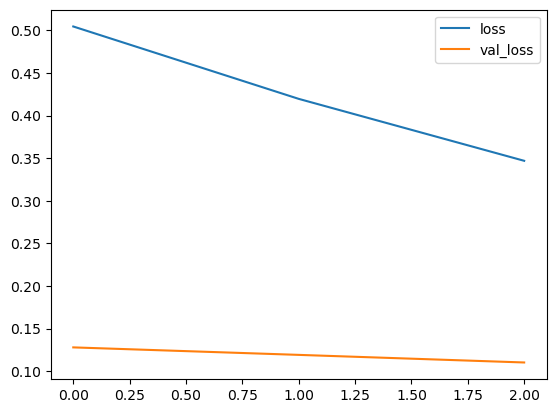

In [7]:
# Build a dataframe with the training history
history_dict = training_history.history
history_df= pd.DataFrame(data = history_dict)

# Plot the training history
fig = history_df.plot.line().get_figure()

# Advanced training history graphs
# %tensorboard --logdir logs


## Visuzalizing the autoencoder architecture
We initialized the autoencoder. But how does it actually look? We can visualize the layers using several methods. 
The easiest one is to use this [website](http://alexlenail.me/NN-SVG/index.html) to manually create the architecture. 

But that doesn't tell us exactly what we are training. 

Another option is to use the built-in tensorflow visualization library. This will show us what we are actually training. However, it is not very visually appealing. 

The most visually appealing and accurate option is Tensorboard. Unfortunately, it is also challenging to use. 

In [8]:
tensorflow.keras.utils.plot_model(ae.model(), to_file='ae_arch.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
# %tensorboard --logdir logs # Use at your own risk :)

### Updating the training parameters
Our model is underfitted. It can still learn more from the training dataset without hurting generalization.  We know this because both the training mean squared error (aka loss) and the testing mean squared error (aka validation loss) are both decreasing. 

Change the epochs and batch size parameters until you see your model overfitting. That is, when the validation loss starts to increase. 

### Compare the performance to the IF and LOF models. 

# Clustering

/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of

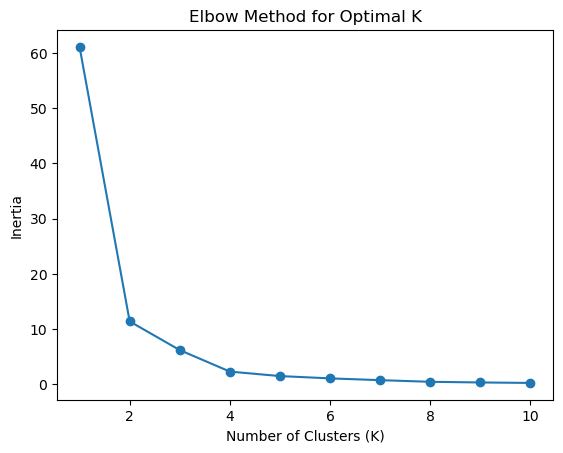

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data_evaluation.csv')
X = data[['bytes_out']]

# Initialize an empty list to store the inertia (within-cluster sum of squares)
inertia = []

# Try a range of K values
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of

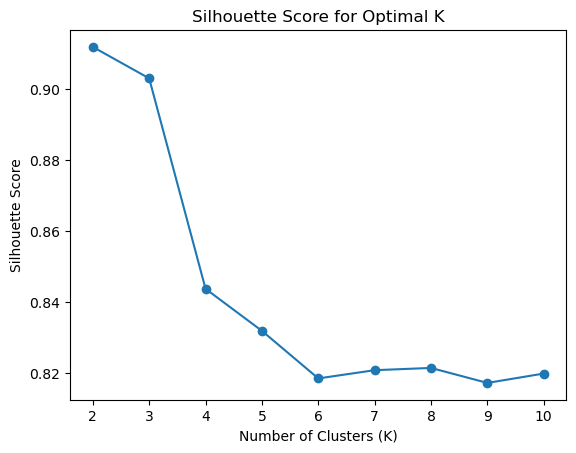

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load your dataset
data = pd.read_csv('data_evaluation.csv')
X = data[['bytes_out']]

# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Try a range of K values
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()


/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


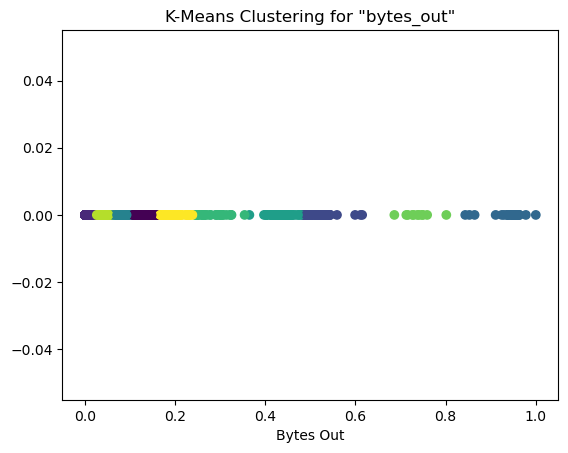

In [29]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data_evaluation.csv')

# Select the feature you want to cluster on (in this case, 'bytes_out')
X = data[['bytes_out']]

# Choose the number of clusters (K) - you need to determine this based on your data or use the elbow method
k = 10  # You can adjust this based on your problem

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

# Add cluster labels to your dataset
data['cluster'] = kmeans.labels_

# Visualize the clusters
plt.scatter(data['bytes_out'], [0] * len(data), c=data['cluster'], cmap='viridis')
plt.xlabel('Bytes Out')
plt.title('K-Means Clustering for "bytes_out"')
plt.show()


/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of

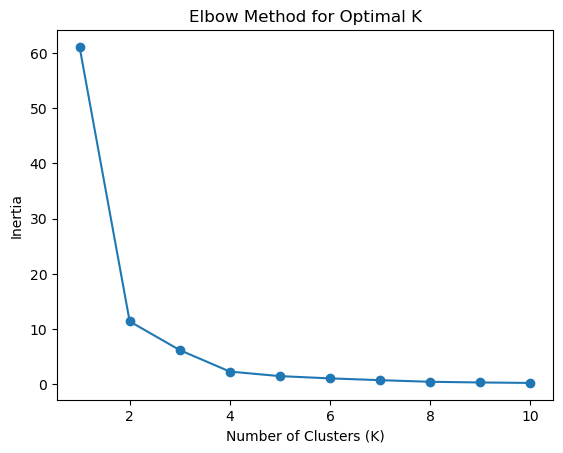

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data_evaluation.csv')
X = data[['bytes_out']]

# Initialize an empty list to store the inertia (within-cluster sum of squares)
inertia = []

# Try a range of K values
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


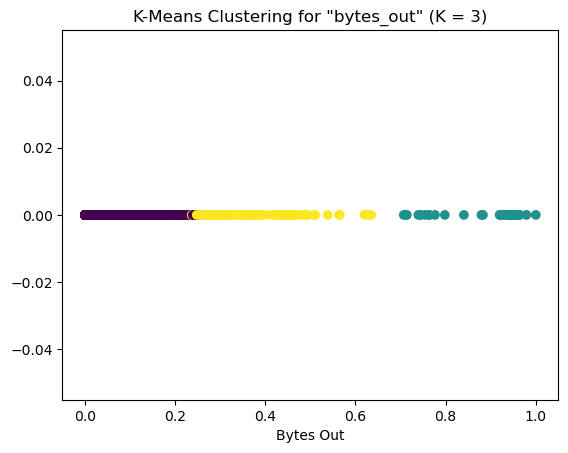

In [19]:
# Based on the Elbow Method, select the optimal K value
optimal_k = 3  # Replace with the value you obtained from the Elbow graph

# Initialize and fit the K-Means model with the optimal K
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(X)

# Add cluster labels to your dataset
data['cluster'] = kmeans.labels_

# Visualize the clusters
plt.scatter(data['num_pkts_in'], [0] * len(data), c=data['cluster'], cmap='viridis')
plt.xlabel('Bytes Out')
plt.title(f'K-Means Clustering for "bytes_out" (K = {optimal_k})')
plt.show()


In [20]:
data.columns

Index(['bytes_out', 'num_pkts_out', 'bytes_in', 'num_pkts_in', 'bytes_ration',
       'num_pkts_ration', 'time', 'av_pkt_size_in', 'av_pkt_size_out',
       'var_pkt_size_in', 'var_pkt_size_out', 'median_in', 'median_out',
       'mindelay', 'avgdelay', 'maxdelay', 'is_doh', 'cluster'],
      dtype='object')

/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of

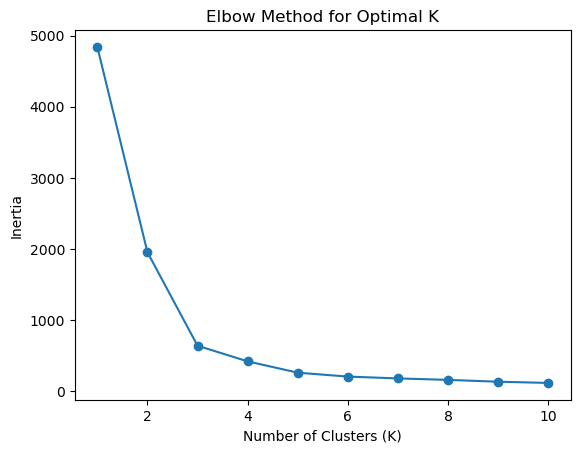

/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


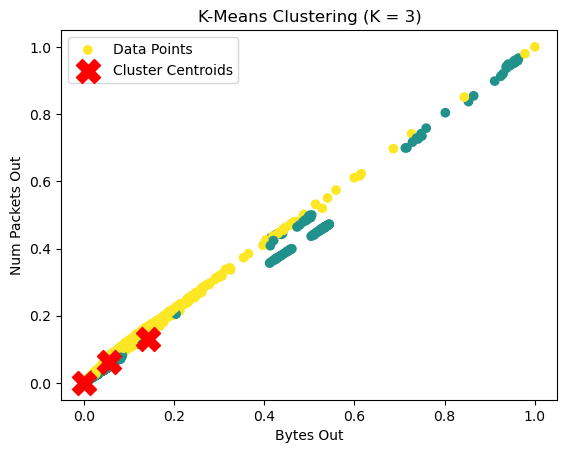

In [22]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data_evaluation.csv')

# Select the features you want to cluster on
features = ['bytes_out', 'num_pkts_out', 'bytes_in', 'num_pkts_in', 'bytes_ration',
            'num_pkts_ration', 'time', 'av_pkt_size_in', 'av_pkt_size_out',
            'var_pkt_size_in', 'var_pkt_size_out', 'median_in', 'median_out',
            'mindelay', 'avgdelay', 'maxdelay', 'is_doh']

X = data[features]

# Determine the optimal K value using the Elbow Method or another method (as shown in previous responses)

# For example, using the Elbow Method:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

# Try a range of K values
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph to select the optimal K value
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Based on the Elbow Method, select the optimal K value
optimal_k = 3  # Replace with the value you obtained from the Elbow graph

# Initialize and fit the K-Means model with the optimal K
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(X)

# Add cluster labels to your dataset
data['cluster'] = kmeans.labels_

# Visualize the clusters and centroids
plt.scatter(data['bytes_out'], data['num_pkts_out'], c=data['cluster'], cmap='viridis', label='Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Cluster Centroids', marker='X')
plt.xlabel('Bytes Out')
plt.ylabel('Num Packets Out')
plt.title(f'K-Means Clustering (K = {optimal_k})')
plt.legend()
plt.show()

# Now, data contains the cluster labels in the 'cluster' column


/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of

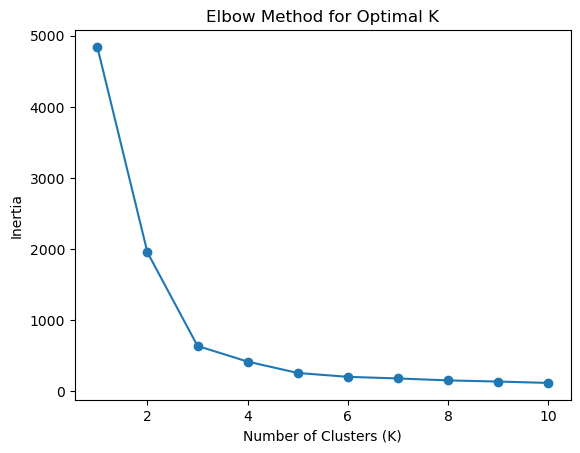

/Users/yoelwoldeyes/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


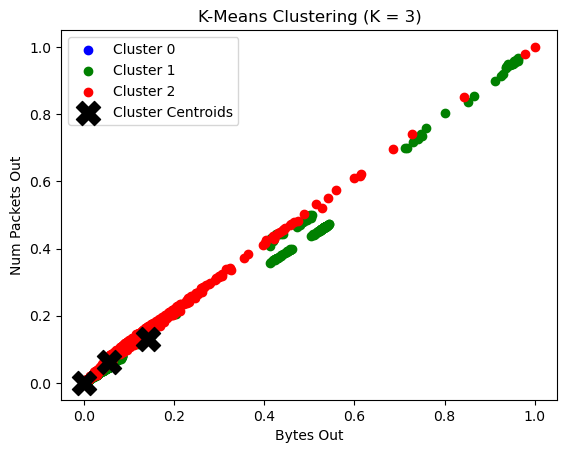

In [25]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
data = pd.read_csv('data_evaluation.csv')

# Select the features you want to cluster on
features = ['bytes_out', 'num_pkts_out', 'bytes_in', 'num_pkts_in', 'bytes_ration',
            'num_pkts_ration', 'time', 'av_pkt_size_in', 'av_pkt_size_out',
            'var_pkt_size_in', 'var_pkt_size_out', 'median_in', 'median_out',
            'mindelay', 'avgdelay', 'maxdelay', 'is_doh']

X = data[features]

# Determine the optimal K value using the Elbow Method or another method (as shown in previous responses)

# For example, using the Elbow Method:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

# Try a range of K values
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph to select the optimal K value
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Based on the Elbow Method, select the optimal K value
optimal_k = 3  # Replace with the value you obtained from the Elbow graph

# Initialize and fit the K-Means model with the optimal K
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(X)

# Add cluster labels to your dataset
data['cluster'] = kmeans.labels_

# Define a list of colors for each cluster
colors = ['b', 'g', 'r']

# Visualize the clusters and centroids
for cluster_label, color in zip(range(optimal_k), colors):
    cluster_data = data[data['cluster'] == cluster_label]
    plt.scatter(cluster_data['bytes_out'], cluster_data['num_pkts_out'], c=color, label=f'Cluster {cluster_label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='black', label='Cluster Centroids', marker='X')
plt.xlabel('Bytes Out')
plt.ylabel('Num Packets Out')
plt.title(f'K-Means Clustering (K = {optimal_k})')
plt.legend()
plt.show()

# Now, data contains the cluster labels in the 'cluster' column
